In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import seaborn as sns

In [2]:
# 이미지 경로 설정
image_paths = glob.glob('output_folder/*.jpg')

In [3]:
# 색상 범위 시각화를 위한 함수
def extract_color_channels(image, color_space='HSV'):
    if color_space == 'HSV':
        hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv_image)
        return h, s, v, 'Hue', 'Saturation', 'Value'
    elif color_space == 'YUV':
        yuv_image = cv.cvtColor(image, cv.COLOR_BGR2YUV)
        _, u, v = cv.split(yuv_image)
        return u, v, None, 'U', 'V', 'Y (ignored)'
    elif color_space == 'YCbCr':
        ycbcr_image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
        _, cb, cr = cv.split(ycbcr_image)
        return cb, cr, None, 'Cb', 'Cr', 'Y (ignored)'
    else:
        raise ValueError("Invalid color space selected.")

In [4]:
# 보라색 원 탐지 및 마스크 생성 함수
def detect_purple(image, color_space='HSV'):
    if color_space == 'HSV':
        lower_purple = np.array([125, 50, 50])
        upper_purple = np.array([150, 255, 255])
        mask = cv.inRange(cv.cvtColor(image, cv.COLOR_BGR2HSV), lower_purple, upper_purple)
    elif color_space == 'YUV':
        lower_purple = np.array([100, 120])  
        upper_purple = np.array([200, 140])
        u, v, _, _, _, _ = extract_color_channels(image, 'YUV')
        mask = cv.inRange(cv.merge((u, v)), lower_purple, upper_purple)
    elif color_space == 'YCbCr':
        lower_purple = np.array([100, 120])  
        upper_purple = np.array([200, 140])
        cb, cr, _, _, _, _ = extract_color_channels(image, 'YCbCr')
        mask = cv.inRange(cv.merge((cb, cr)), lower_purple, upper_purple)
    else:
        raise ValueError("Invalid color space selected.")
    
    result = cv.bitwise_and(image, image, mask=mask)
    return mask, result

In [5]:
# 각 색상 공간별 보라색 픽셀 분포 시각화
def visualize_color_distributions(image_paths):
    color_spaces = ['HSV', 'YUV', 'YCbCr']
    for color_space in color_spaces:
        h_values, s_values, v_values = [], [], []
        
        for image_path in image_paths:
            img = cv.imread(image_path)
            ch1, ch2, ch3, ch1_name, ch2_name, ch3_name = extract_color_channels(img, color_space=color_space)
            
            # 채널 분포 수집
            h_values.extend(ch1.ravel())
            if ch2 is not None:
                s_values.extend(ch2.ravel())
            if ch3 is not None:
                v_values.extend(ch3.ravel())
        
        # 채널별 분포 시각화
        plt.figure(figsize=(12, 4))
        sns.histplot(h_values, bins=50, color='purple', kde=True, label=ch1_name)
        plt.title(f'{color_space} - {ch1_name} Distribution')
        plt.xlabel('Intensity')
        plt.legend()
        plt.show()

        if ch2 is not None:
            plt.figure(figsize=(12, 4))
            sns.histplot(s_values, bins=50, color='blue', kde=True, label=ch2_name)
            plt.title(f'{color_space} - {ch2_name} Distribution')
            plt.xlabel('Intensity')
            plt.legend()
            plt.show()

        if ch3 is not None:
            plt.figure(figsize=(12, 4))
            sns.histplot(v_values, bins=50, color='green', kde=True, label=ch3_name)
            plt.title(f'{color_space} - {ch3_name} Distribution')
            plt.xlabel('Intensity')
            plt.legend()
            plt.show()

In [6]:
# 밝은 환경과 어두운 환경을 위한 성능 비교
# 탐지 성능 비교 시각화 및 분석
def analyze_performance(image_paths):
    results = {'HSV': [], 'YUV': [], 'YCbCr': []}
    
    # 각 이미지에서 색상 공간별 탐지된 보라색 픽셀 수를 계산
    for image_path in image_paths:
        img = cv.imread(image_path)
        for color_space in results.keys():
            mask, _ = detect_purple(img, color_space=color_space)
            purple_pixels = np.sum(mask > 0)
            results[color_space].append(purple_pixels)
    
    # 데이터를 DataFrame으로 변환
    results_df = pd.DataFrame({
        'Color Space': np.repeat(list(results.keys()), [len(results[k]) for k in results.keys()]),
        'Detected Pixels': np.concatenate(list(results.values()))
    })
    
    # Boxplot과 Scatter Plot을 함께 시각화
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df, x='Color Space', y='Detected Pixels', palette="Set2", width=0.6, fliersize=0)
    sns.stripplot(data=results_df, x='Color Space', y='Detected Pixels', color='black', size=4, jitter=0.15, alpha=0.7)
    
    # 스타일 및 제목 설정
    plt.title('탐지한 purple pixel color 값')
    plt.ylabel('탐지한 purple pixel 수')
    plt.xlabel('색상범위')
    plt.tight_layout()
    plt.show()
    
    # 중앙값 계산 및 성능이 가장 좋은 색상 공간 찾기
    median_values = results_df.groupby('Color Space')['Detected Pixels'].median()
    best_color_space = median_values.idxmax()  # 가장 높은 중앙값을 가진 색상 공간
    best_value = median_values.max()

    # 결과 출력
    print(f"성능 best 방법 : {best_color_space}")
    print(f"{best_color_space}의 중앙값 (탐지된 보라색 픽셀 수) : {best_value}")
    
    return best_color_space, best_value

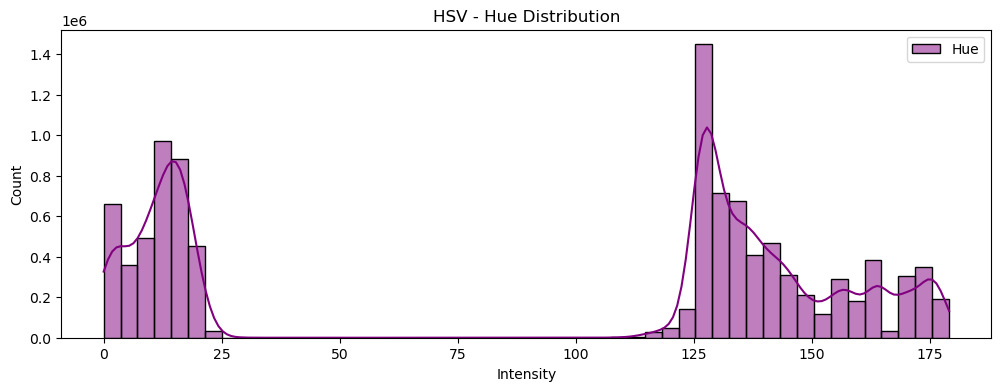

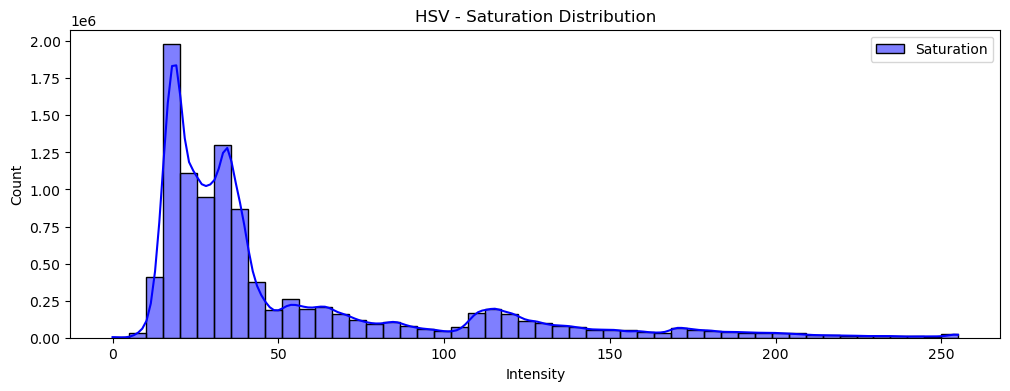

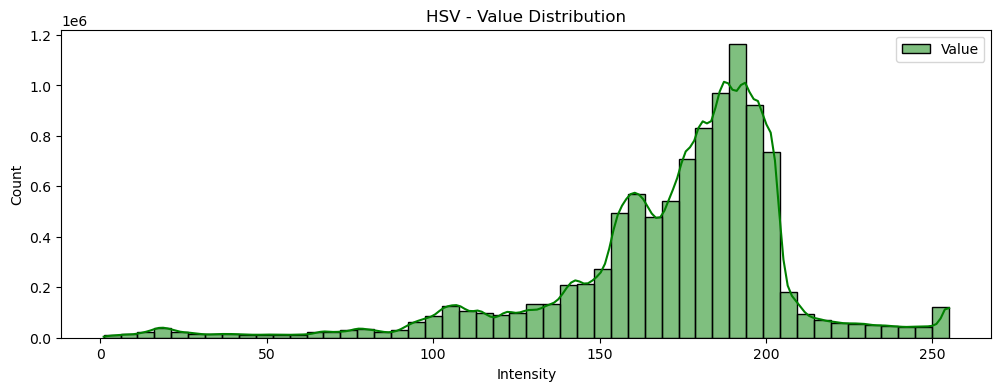

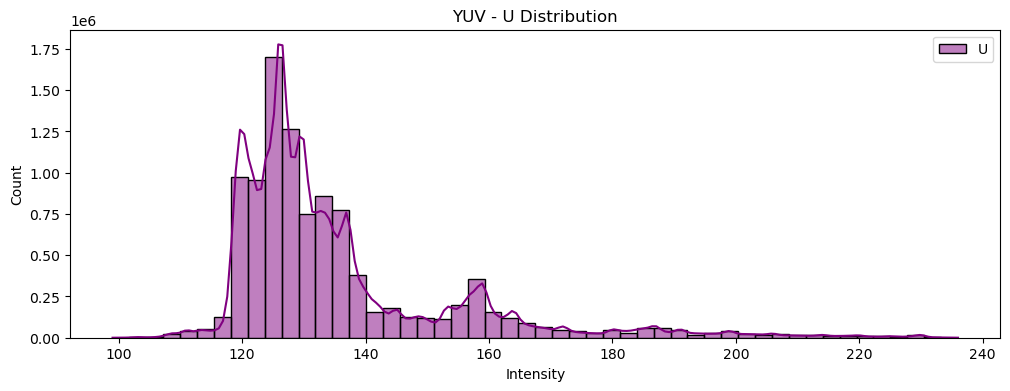

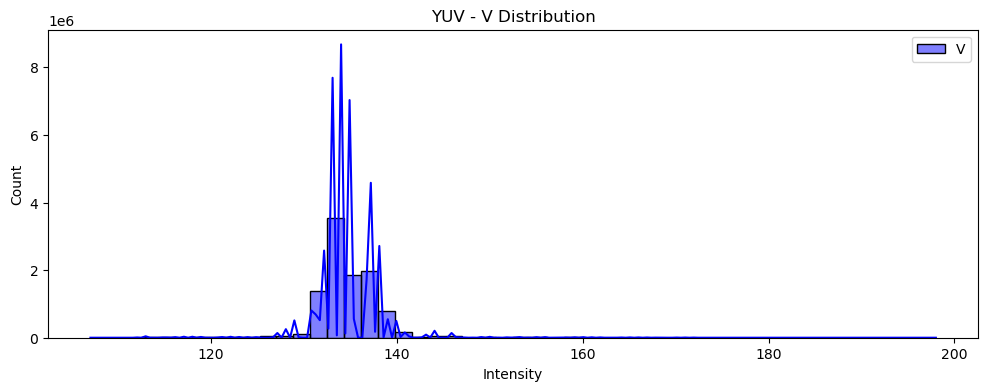

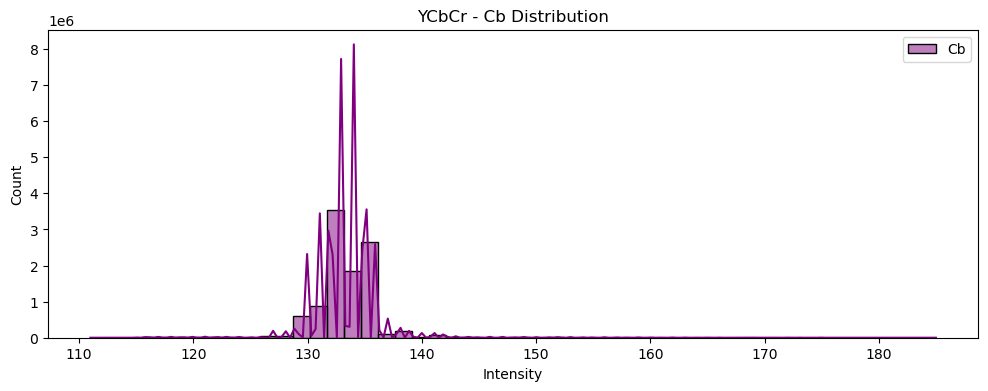

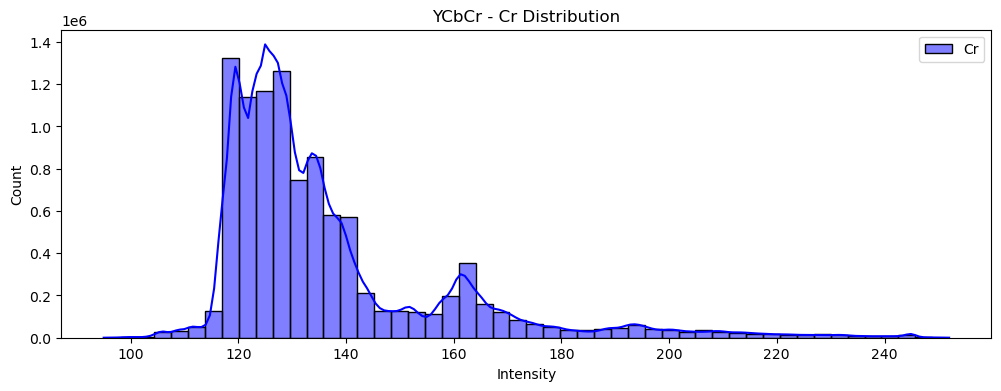

In [7]:
# 실행
# 이미지 샘플에서 보라색 픽셀 분포 시각화
random_image_paths = random.sample(image_paths, 5)
visualize_color_distributions(random_image_paths)

/var/folders/my/bphk0twx0r7dx_xpdxkb918m0000gn/T/ipykernel_90927/1615981668.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Color Space', y='Detected Pixels', palette="Set2", width=0.6, fliersize=0)
/var/folders/my/bphk0twx0r7dx_xpdxkb918m0000gn/T/ipykernel_90927/1615981668.py:29: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/bphk0twx0r7dx_xpdxkb918m0000gn/T/ipykernel_90927/1615981668.py:29: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/bphk0twx0r7dx_xpdxkb918m0000gn/T/ipykernel_90927/1615981668.py:29: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/bphk0twx0r7dx_xpdxkb918m0000gn/T/ipyker

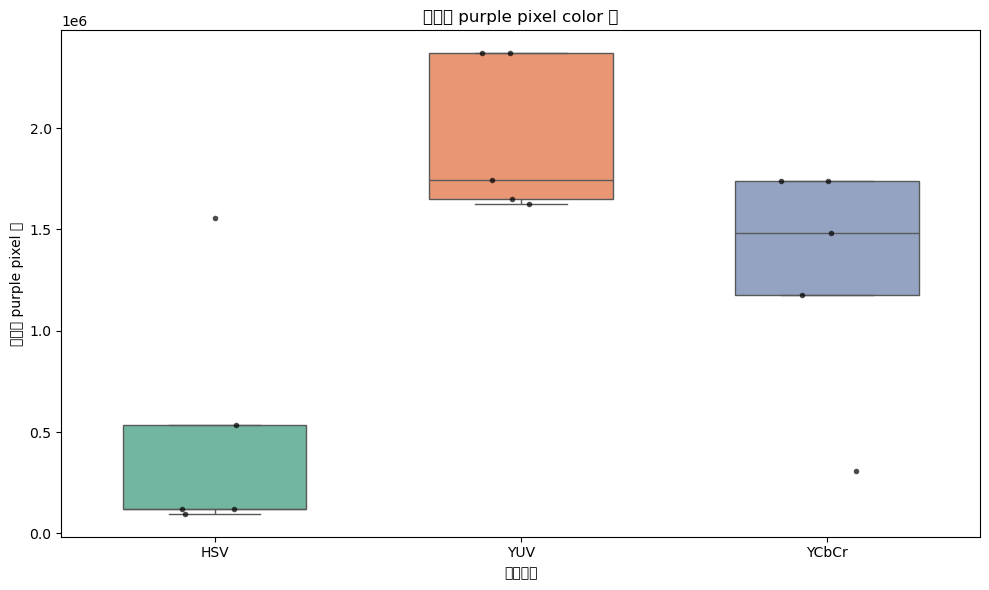

성능 best 방법 : YUV
YUV의 중앙값 (탐지된 보라색 픽셀 수) : 1742791.0


('YUV', np.float64(1742791.0))

In [8]:
# 탐지 성능 비교 시각화
analyze_performance(random_image_paths)

In [9]:
# 확률 맵 생성 함수
def create_probability_map(image, target_uv, threshold=40):
    """
    UV 채널 기반 확률 맵 생성 함수
    - image: 입력 이미지 (BGR 형식)
    - target_uv: 보라색을 나타내는 UV 값 (예: [130, 140])
    - threshold: 거리의 허용 범위 (예: 40)
    """
    # YUV 색상 공간으로 변환
    yuv_img = cv.cvtColor(image, cv.COLOR_BGR2YUV)
    _, u, v = cv.split(yuv_img)
    
    # UV 값과의 거리 계산
    u_diff = np.abs(u - target_uv[0])
    v_diff = np.abs(v - target_uv[1])
    
    # 확률 맵 생성 정규화 (0~1 범위로 변환)
    prob_map = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))
    
    return prob_map

In [10]:
# 히스토그램 시각화 함수
def visualize_probability_map(prob_map, title="Probability Map", threshold=0.8):
    """
    확률 맵의 히스토그램 시각화
    - prob_map: 확률 맵 (0~1 범위의 값)
    """
    
    plt.figure(figsize=(8, 8))
    plt.imshow(prob_map, cmap='viridis')
    plt.colorbar(label="Probability")
    plt.title(title)
    plt.show()

    # 특정 확률 이상 영역 강조
    binary_mask = prob_map > threshold
    plt.figure(figsize=(8, 8))
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Highlighted Regions (Threshold: {threshold})")
    plt.show()

In [11]:
# 히스토그램 시각화
def visualize_probability_histogram(prob_map):
    plt.figure(figsize=(10, 6))
    sns.histplot(prob_map.ravel(), bins=50, kde=True, color='purple')
    plt.title("Probability Map Histogram")
    plt.xlabel("Probability Value")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.show()

In [12]:
# UV 목표값 설정 (보라색 범위 예제)
target_uv = [130, 140]  # UV 기준값
threshold = 40  # 거리 허용 범위

In [13]:
image_1 = '/Users/hyunowk/Downloads/aiclopse_hyun/output_folder/augmented_0_1.jpg'
image_1 = cv.imread(image_1)

In [15]:
# 확률 맵 생성 및 히스토그램 시각화
probability_map = create_probability_map(image_1, target_uv, threshold)
visualize_probability_histogram(probability_map)

UnboundLocalError: local variable 'prob_map' referenced before assignment

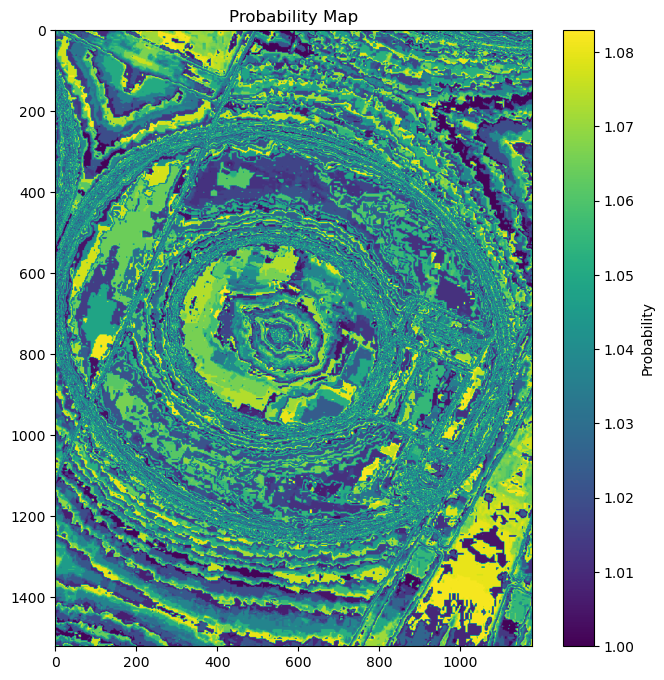

In [31]:
# 확률 맵 시각화
plt.figure(figsize=(8, 8))
plt.imshow(probability_map, cmap='viridis')
plt.title("Probability Map")
plt.colorbar(label="Probability")
plt.show()

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 보라색 UV 채널 분포 시각화 함수
def visualize_purple_uv(image_paths):
    uv_values = []

    # 이미지를 순회하면서 UV 채널 값 추출
    for image_path in image_paths:
        img = cv.imread(image_path)
        yuv_img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
        _, u, v = cv.split(yuv_img)

        # 보라색에 해당하는 UV 값 저장
        purple_mask = (u > 130) & (u < 170) & (v > 140) & (v < 190)
        uv_values.append(np.column_stack((u[purple_mask], v[purple_mask])))

    # UV 데이터를 합침
    uv_values = np.vstack(uv_values)
    u_values, v_values = uv_values[:, 0], uv_values[:, 1]

    # 파이 차트: U 채널 주요 범위 비율
    uv_bins = np.round(u_values / 10) * 10  # U 채널을 10단위로 그룹화
    unique_bins, counts = np.unique(uv_bins, return_counts=True)
    colors = sns.color_palette("pastel", len(unique_bins))

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=unique_bins.astype(int), autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title("U Channel Distribution (random 100개에 대하여)", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 히스토그램: UV 채널의 데이터 분포 (파스텔 톤)
    plt.figure(figsize=(10, 6))
    sns.histplot(u_values, bins=30, kde=False, color='#AEC6CF', label="U Channel", alpha=0.8)
    sns.histplot(v_values, bins=30, kde=False, color='#FFB347', label="V Channel", alpha=0.8)

    plt.title("UV Histogram", fontsize=14)
    plt.xlabel("U or V channel 값 (Channel Value)", fontsize=12)
    plt.ylabel("빈도수(frequency)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 보라색 범위의 UV 색상 분포 시각화
def purple_uvuv(image_paths):
    uv_values = []

    # 이미지를 순회하면서 UV 채널 값 추출
    for image_path in image_paths:
        img = cv.imread(image_path)
        yuv_img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
        _, u, v = cv.split(yuv_img)

        # 보라색에 해당하는 UV 값 저장 (임계값 조정 가능)
        purple_mask = (u > 130) & (u < 170) & (v > 140) & (v < 190)
        uv_values.append(np.column_stack((u[purple_mask], v[purple_mask])))

    # UV 데이터를 합침
    uv_values = np.vstack(uv_values)

    # UV 채널의 데이터 분포를 시각화
    u_values, v_values = uv_values[:, 0], uv_values[:, 1]

    # UV 분포 시각화: 원그래프
    plt.figure(figsize=(10, 6))
    plt.scatter(u_values, v_values, c='purple', alpha=0.5, edgecolors='k')
    plt.title("UV Channel Distribution for Purple")
    plt.xlabel("U Channel")
    plt.ylabel("V Channel")
    plt.grid(alpha=0.3)
    plt.show()

    # UV 범위에 따른 히스토그램
    plt.figure(figsize=(10, 6))
    sns.histplot(u_values, bins=30, kde=False, color='blue', label="U Channel", alpha=0.7)
    sns.histplot(v_values, bins=30, kde=False, color='red', label="V Channel", alpha=0.7)
    plt.title("UV Histogram for Purple Range")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # UV 범위를 파이차트로 시각화 (대략적인 비율)
    uv_ratio, counts = np.unique(np.round(u_values / 10) * 10, return_counts=True)
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=uv_ratio.astype(int), autopct='%1.1f%%', colors=plt.cm.Purples(np.linspace(0.3, 0.9, len(counts))))
    plt.title("U Channel Distribution")
    plt.show()

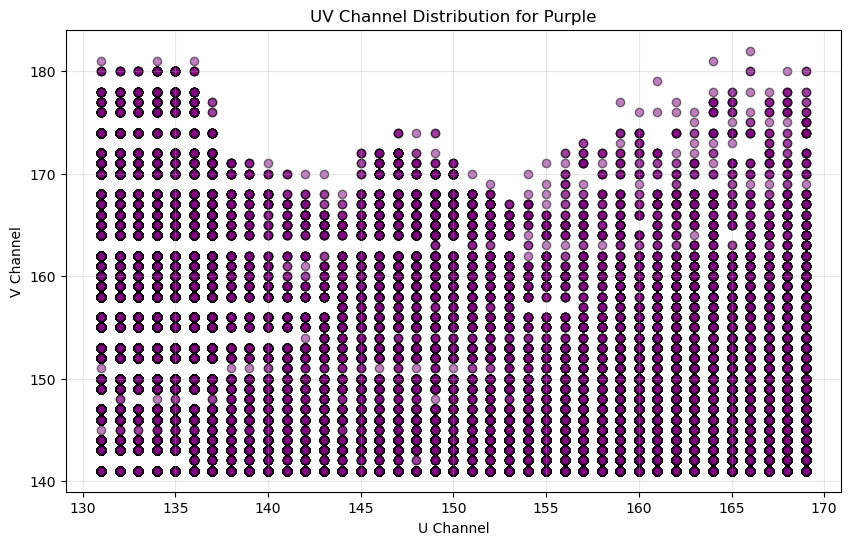

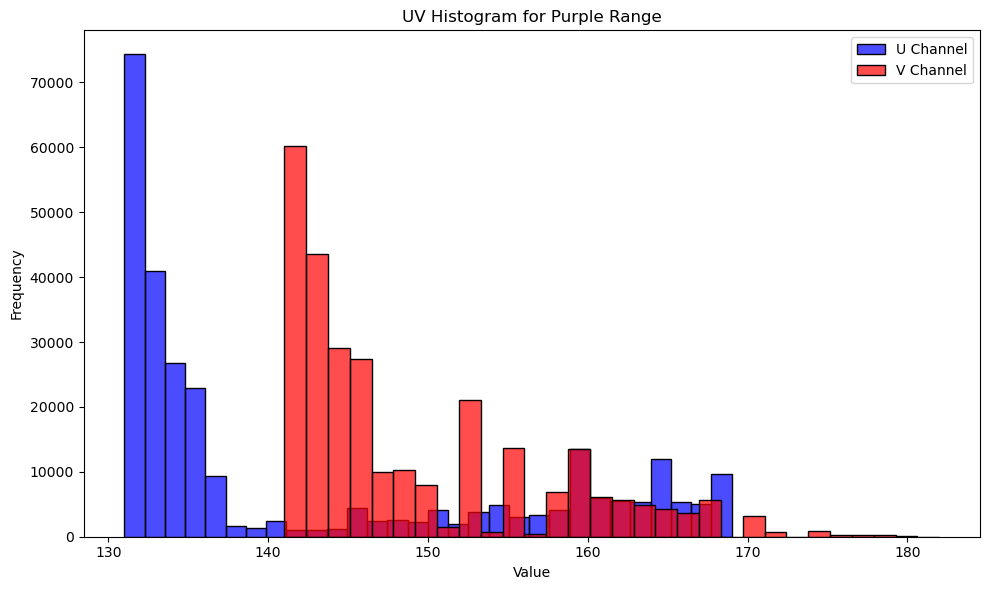

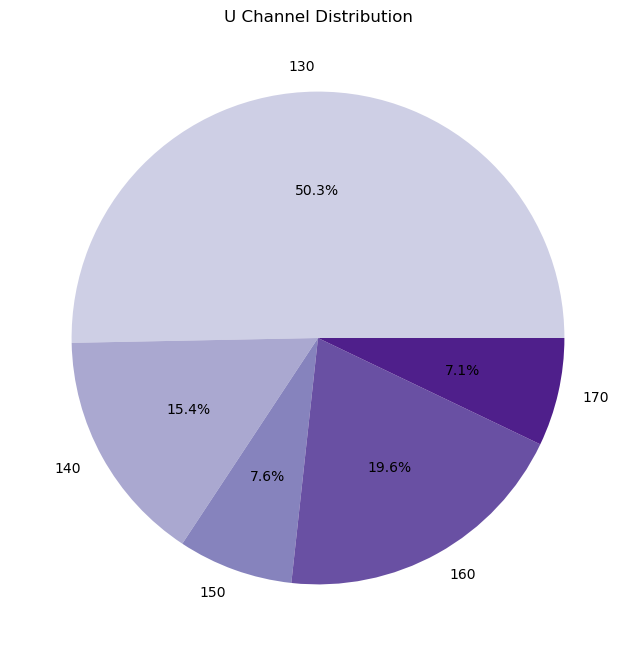

In [18]:
# 실행
# 이미지 샘플에서 보라색 픽셀 분포 시각화
random_image_uv = random.sample(image_paths, 100)
purple_uvuv(random_image_uv)